### ep2-julia: logistic regression

### Logistic regression

We will use the formulation described in the textbook (<i>Learning from data</i>, Abu-Mostafa <i>et al.</i>). Positive class label equals +1 and negative equals -1.

The loss (or error) function to be minimized is
$$
E_{in}(\mathbf{w}) = \frac{1}{N} \sum_{i=1}^{N} \ln(1 + e^{-y^{(i)} \mathbf{w}^T \mathbf{x}^{(i)}}) \tag{1}
$$

Its (ascent) gradient (the minus sign in the formula is correct!) is given by

$$\nabla E_{in}(\mathbf{w}) = - \frac{1}{N}\sum_{i=1}^{N} \frac{y^{(i)} \mathbf{x}^{(i)}}{1 + e^{y^{(i)} \mathbf{w}^T \mathbf{x}^{(i)}}}  \tag{2}$$

The logistic (sigmoid) function is
$$\sigma(z) = \frac{1}{1 + e^{-z}}  \tag{3}$$

In [1]:
# libraries
using Random
using Distributions
using Plots; gr()
using Printf

using MLJ              # blobs
using DataFrames

In [2]:
function cross_entropy_loss(w, X, y)
    xpn = -y .* (X * w)
    res = log.(1 .+ exp.(xpn))
    loss = mean(res)
end

# teste da função
X_teste = [1 2 4;
           3 2 6;
           7 9 3;
           12 1 7]
N, d = size(X_teste)

y_teste = [1;
           -1;
           -1;
           1]

rng = Random.seed!(1)            # generate seed
w_teste = randn(rng, d)          # generate initial w vector
display(w_teste)

cross_entropy_loss(w_teste, X_teste, y_teste)


3-element Array{Float64,1}:
  0.2972879845354616
  0.3823959677906078
 -0.5976344767282311

1.5673053843772515

In [3]:
# computes the gradient (ascent)
# Note: gradient descent = - gradient ascent
function cross_entropy_gradient(w, X, y)
    xpn = -y .* (X * w)

    numerator = (y .* X)
    denominator = 1 .+ exp.(xpn)
    res = numerator ./ denominator
    grad = -mean(res, dims=1)'
end

# teste da função
cross_entropy_gradient(w_teste, X_teste, y_teste)

3×1 LinearAlgebra.Adjoint{Float64,Array{Float64,2}}:
 -0.6820705486989405
  0.274139435204393
  0.3446304039513245

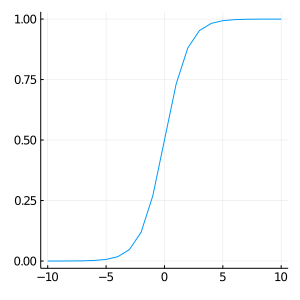

In [4]:
sigmoid(z) = 1 ./ (1 .+ exp.(-z))

# teste da função
a = -10:10
b = sigmoid(a)
plot(a, b, legend=false, size=(300,300))

In [5]:
function train_logistic(X, y, learning_rate = 0.1, epochs = 5000)

    N, d = size(X)
    Xe = hcat(ones(N), X)      # add ones to first column

    rng = Random.seed!(9)      # generate seed
    w0 = randn(rng, d+1)       # generate random initial w vector
    
    wt = copy(w0)
    w_history = Vector{Matrix{Float64}}()
    cross_entropy_loss_history = []         # = Vector{Float64}()
    
    for t in 1:epochs
        loss_t = cross_entropy_loss(wt, Xe, y)   # calculate the error
        
        push!(w_history, wt')
        push!(cross_entropy_loss_history, loss_t)
        
        gt = cross_entropy_gradient(wt, Xe, y)   # get the gradient
        vt = -gt                                 # get the descent gradient
        wt = wt + learning_rate .* vt            # compute the weight
    end
    
    w = w_history[argmin(cross_entropy_loss_history)]'   # get the final weight which equals minimum error
    
    return (w, w_history, cross_entropy_loss_history)
end

# teste da função
w_logistic, w_history, cross_entropy_loss_history = train_logistic(X_teste, y_teste, 0.1, 10)
#display(w_logistic)
#display(w_history)
display(cross_entropy_loss_history)

10-element Array{Any,1}:
  0.9423306842377435
  1.7134921714900784
  3.086508186303156
  4.698948573118682
  6.354064329552007
  8.015403008216946
  9.67771010330214
 11.340177197658974
 13.002671521428283
 14.665170537878698

In [6]:
function predict_logistic(w, X)
    N  = size(X)[1]
    Xe = hcat(ones(N), X)
    p  = sigmoid(Xe * w)
end

# teste da função
rng = Random.seed!(1)
w_teste = randn(rng, d+1)
predict_logistic(w_teste, X_teste)

4-element Array{Float64,1}:
 0.36415713997313365
 0.5464991148634797
 0.08046940511407982
 0.9854468597627305

### Example project - generate data (blobs)

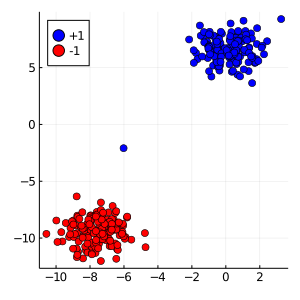

In [7]:
N = 300
X, y = make_blobs(N, 2; centers=2, cluster_std = 1, rng=6)
X = DataFrame(X) |> Array
y[ y .== 2 ] .= -1
y = y |> Array
y = y .|> Float64

scatter(X[y .== 1, 1], X[y .== 1, 2], markercolor = "blue", label = "+1", legend = :topleft, size=(300,300))
scatter!(X[y .== -1, 1], X[y .== -1, 2],  markercolor = "red",  label = "-1")

Iteração p/ erro mínimo: 22
Erro mínimo: 0.025337191083833168
Weight para erro mínimo: [-1.0218289000813623; 0.19162075528570183; 0.7477070379631461]


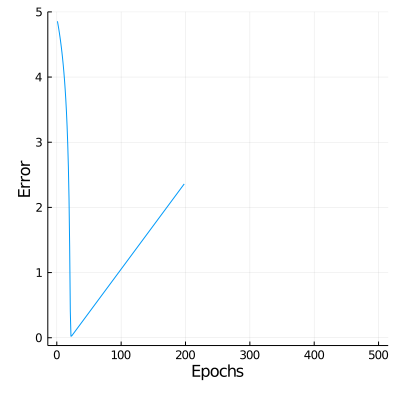

In [8]:
epochs = 500
wl, w_history, loss_history = train_logistic(X, y, 1e-1, epochs)
ind = argmin(loss_history)

println("Iteração p/ erro mínimo: ", ind)
println("Erro mínimo: ", loss_history[ind])
println("Weight para erro mínimo: ", wl)

plot(1:epochs, loss_history, legend=false, xlabel = "Epochs", ylabel = "Error", size=(400,400))

In [9]:
function p_to_y(p, threshold = 0.5)
    ŷ = [ (i > threshold ? 1 : -1) for i in p]
    ŷ = vec(ŷ)  # transforma array (N,1) em (N,)
end

p = predict_logistic(wl, X)
ŷ = p_to_y(p)
size(ŷ)

(300,)

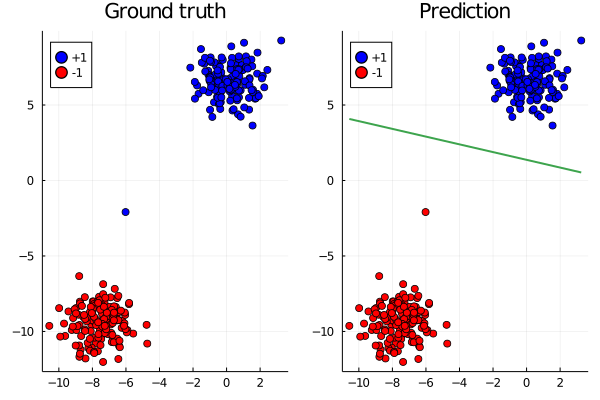

In [10]:
# ground truth plot
p1 = scatter(X[y .== 1, 1], X[y .== 1, 2], markercolor = "blue", label = "+1", )
p1 = scatter!(X[y .== -1, 1], X[y .== -1, 2],  markercolor = "red",  label = "-1")
p1 = title!("Ground truth")

# prediction plot
p2 = scatter(X[ŷ .== 1, 1], X[ŷ .== 1, 2], markercolor = "blue", label = "+1")
p2 = scatter!(X[ŷ .== -1, 1], X[ŷ .== -1, 2],  markercolor = "red",  label = "-1")
p2 = title!("Prediction")

# add hyperplane to prediction plot
x1min = minimum(X[:,1])   # min() max() não funciona com arrays, apenas com listas
x1max = maximum(X[:,1])
x2min = minimum(X[:,2])
x2max = maximum(X[:,2])

d1 = (x1min, -(wl[1] + (x1min)*wl[2])/wl[3])
d2 = (x1max, -(wl[1] + (x1max)*wl[2])/wl[3])
p2 = plot!([d1, d2], width=2, label=false)   # plot de linha ligando d1 a d2

# show all plots
plot(p1, p2, layout=(1,2), legend=:topleft)